# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial
from scipy import stats as st
import math as mt
from scipy.stats import levene

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv("/datasets/megaline_users.csv")
df_calls = pd.read_csv("/datasets/megaline_calls.csv")
df_msg = pd.read_csv("/datasets/megaline_messages.csv")
df_wifi = pd.read_csv("/datasets/megaline_internet.csv")
df_plans = pd.read_csv("/datasets/megaline_plans.csv")

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

In [3]:
print("Información de los usuarios:")
display(df_users.head(5))
print("Información de las llamadas:")
display(df_calls.head(5))
print("Información de los mensajes:")
display(df_msg.head(5))
print("Información del internet:")
display(df_wifi.head(5))
print("Información de los planes:")
display(df_plans.head(5))

Información de los usuarios:


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Información de las llamadas:


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Información de los mensajes:


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Información del internet:


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Información de los planes:


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
# Imprime una muestra de los datos para las tarifas
display(df_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

**Primero que nada yo cambiaría el orden de las columnas ya que es confuso estar buscando por ejemplo el plan y cual es su precio al mes o ver los MB que incluye un paquete y su precio por excedete.**

**Después del paso anterior, ahora convertiría la columna usd_per_gb a usd_per_mb para sacar la conversión del precio excedente por MB, ya que todos los datos de internet de los otros dataframes están en megabytes.También convertiría la columna usd_per_gb a float para poder dividirla entre 1024 mb**

### Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [6]:
# Primero voy a ordenar las columnas del DataFrame.
df_plans = df_plans[["plan_name","usd_monthly_pay","minutes_included","usd_per_minute","messages_included","usd_per_message","mb_per_month_included","usd_per_gb"]]
df_plans = df_plans.rename(columns={"usd_per_gb":"usd_per_mb"})
df_plans["usd_per_mb"] = df_plans["usd_per_mb"].astype("float")

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [7]:
df_plans["usd_per_mb"] = df_plans["usd_per_mb"] / 1024

## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
display(df_users.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

**De la columan user_id pasaría el tipo de dato a object, las columnas de nombre y apellido las haría minúsculas, ciudad también a minúsculas, reg_date y churn_date a tipo datetime**


### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [10]:
df_users["user_id"] = df_users["user_id"].astype("object")                        # Conversión de tipo int a object
df_users["reg_date"] = pd.to_datetime(df_users["reg_date"],format="%Y-%m-%d")     # Convertir a datetime
df_users["churn_date"] = pd.to_datetime(df_users["churn_date"],format="%Y-%m-%d") # Convertir a datetime

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [11]:
df_users["first_name"] = df_users["first_name"].str.lower()                       # Conversión a minúsculas 
df_users["last_name"] = df_users["last_name"].str.lower()                         # Conversión a minúsculas 
df_users["city"] = df_users["city"].str.lower()                                   # Conversión a minúsculas 

## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
display(df_calls.head())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

**Yo cambiaría el tipo de user_id a tipo object, call_date a datetime y reacomodaría las columnas**

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [14]:
df_calls = df_calls[["user_id","id","duration","call_date"]]
df_calls["user_id"] = df_calls["user_id"].astype("object")                        # Conversión de tipo int a object 
df_calls["call_date"] = pd.to_datetime(df_calls["call_date"],format="%Y-%m-%d")   # Convertir a datetime

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
display(df_msg.head())

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

**Yo cambiaría el tipo de user_id a tipo object, call_date a datetime y reacomodaría las columnas**

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [17]:
df_msg = df_msg[["user_id","id","message_date"]]
df_msg["user_id"] = df_msg["user_id"].astype("object")                              # Conversión de tipo int a object 
df_msg["message_date"] = pd.to_datetime(df_msg["message_date"],format="%Y-%m-%d")   # Convertir a datetime

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_wifi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
display(df_wifi.head())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

**Yo cambiaría el tipo de user_id a tipo object, call_date a datetime y reacomodaría las columnas**

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [20]:
df_wifi = df_wifi[["user_id","id","mb_used","session_date"]]
df_wifi["user_id"] = df_wifi["user_id"].astype("object")                              # Conversión de tipo int a object 
df_wifi["session_date"] = pd.to_datetime(df_wifi["session_date"],format="%Y-%m-%d")   # Convertir a datetime 

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [21]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
df_plans = df_plans.rename(columns={"plan_name":"plan"})
display(df_plans)

,plan,usd_monthly_pay,minutes_included,usd_per_minute,messages_included,usd_per_message,mb_per_month_included,usd_per_mb
0,surf,20,500,0.03,50,0.03,15360,0.009766
1,ultimate,70,3000,0.01,1000,0.01,30720,0.006836


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [22]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
df_calls["month"] = df_calls["call_date"].dt.month
df_calls_per_month = df_calls.groupby(by=["user_id","month"]).count()
df_calls_per_month = df_calls_per_month.reset_index()
df_calls_per_month = df_calls_per_month.drop(["duration","call_date"],axis=1)
df_calls_per_month = df_calls_per_month.rename(columns={"id":"calls_per_month"})
print(df_calls_per_month)

      user_id  month  calls_per_month
0        1000     12               16
1        1001      8               27
2        1001      9               49
3        1001     10               65
4        1001     11               64
...       ...    ...              ...
2253     1498     12               39
2254     1499      9               41
2255     1499     10               53
2256     1499     11               45
2257     1499     12               65

[2258 rows x 3 columns]


In [23]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
df_time_calls_per_month = df_calls.drop(["call_date","id"],axis=1)
df_time_calls_per_month = df_time_calls_per_month.groupby(by=["user_id","month"]).sum()
df_time_calls_per_month = df_time_calls_per_month.reset_index()
print(df_time_calls_per_month)

      user_id  month  duration
0        1000     12    116.83
1        1001      8    171.14
2        1001      9    297.69
3        1001     10    374.11
4        1001     11    404.59
...       ...    ...       ...
2253     1498     12    324.77
2254     1499      9    330.37
2255     1499     10    363.28
2256     1499     11    288.56
2257     1499     12    468.10

[2258 rows x 3 columns]


In [24]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_msg["month"] = df_msg["message_date"].dt.month
df_msg_per_month = df_msg.groupby(["user_id","month"]).count()
df_msg_per_month = df_msg_per_month.reset_index()
df_msg_per_month = df_msg_per_month.drop("message_date",axis=1)
df_msg_per_month = df_msg_per_month.rename(columns={"id":"quantity_msg"})
print(df_msg_per_month)

      user_id  month  quantity_msg
0        1000     12            11
1        1001      8            30
2        1001      9            44
3        1001     10            53
4        1001     11            36
...       ...    ...           ...
1801     1496      9            21
1802     1496     10            18
1803     1496     11            13
1804     1496     12            11
1805     1497     12            50

[1806 rows x 3 columns]


In [25]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
df_wifi["month"] = df_wifi["session_date"].dt.month
df_wifi = df_wifi.drop(["session_date","id"],axis=1)
df_wifi_per_month = df_wifi.groupby(["user_id","month"]).sum()
df_wifi_per_month = df_wifi_per_month.reset_index()
print(df_wifi_per_month)

      user_id  month   mb_used
0        1000     12   1901.47
1        1001      8   6919.15
2        1001      9  13314.82
3        1001     10  22330.49
4        1001     11  18504.30
...       ...    ...       ...
2272     1498     12  23137.69
2273     1499      9  12984.76
2274     1499     10  19492.43
2275     1499     11  16813.83
2276     1499     12  22059.21

[2277 rows x 3 columns]


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [26]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
general_df = df_calls_per_month.merge(df_time_calls_per_month,on=["user_id","month"])
general_df = general_df.merge(df_msg_per_month,on=["user_id","month"],how="outer")
general_df = general_df.merge(df_wifi_per_month,on=["user_id","month"],how="outer")
print(general_df)

      user_id  month  calls_per_month  duration  quantity_msg   mb_used
0        1000     12             16.0    116.83          11.0   1901.47
1        1001      8             27.0    171.14          30.0   6919.15
2        1001      9             49.0    297.69          44.0  13314.82
3        1001     10             65.0    374.11          53.0  22330.49
4        1001     11             64.0    404.59          36.0  18504.30
...       ...    ...              ...       ...           ...       ...
2288     1349     12              NaN       NaN          61.0  13039.91
2289     1361      5              NaN       NaN           2.0   1519.69
2290     1482     10              NaN       NaN           2.0       NaN
2291     1108     12              NaN       NaN           NaN    233.17
2292     1311      6              NaN       NaN           NaN   1498.83

[2293 rows x 6 columns]


In [27]:
# Añade la información de la tarifa
general_df = general_df.merge(df_users,on="user_id")
general_df = general_df.drop(["first_name","last_name","age","city","reg_date","churn_date"],axis=1)
general_df = general_df.merge(df_plans,on="plan")
general_df = general_df[["user_id","plan","usd_monthly_pay","month","minutes_included","calls_per_month","duration","usd_per_minute","messages_included","quantity_msg","usd_per_message","mb_per_month_included","mb_used","usd_per_mb"]]
display(general_df)

,user_id,plan,usd_monthly_pay,month,minutes_included,calls_per_month,duration,usd_per_minute,messages_included,quantity_msg,usd_per_message,mb_per_month_included,mb_used,usd_per_mb
0,1000,ultimate,70,12,3000,16.0,116.83,0.01,1000,11.0,0.01,30720,1901.47,0.006836
1,1006,ultimate,70,11,3000,2.0,9.32,0.01,1000,15.0,0.01,30720,2068.37,0.006836
2,1006,ultimate,70,12,3000,9.0,54.79,0.01,1000,139.0,0.01,30720,32118.82,0.006836
3,1008,ultimate,70,10,3000,71.0,450.21,0.01,1000,21.0,0.01,30720,17106.99,0.006836
4,1008,ultimate,70,11,3000,63.0,422.81,0.01,1000,37.0,0.01,30720,23676.72,0.006836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,surf,20,11,500,NaN,NaN,0.03,50,62.0,0.03,15360,42866.10,0.009766
2289,1194,surf,20,12,500,NaN,NaN,0.03,50,56.0,0.03,15360,31088.49,0.009766
2290,1349,surf,20,10,500,NaN,NaN,0.03,50,76.0,0.03,15360,13093.55,0.009766
2291,1349,surf,20,11,500,NaN,NaN,0.03,50,72.0,0.03,15360,17128.26,0.009766


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [28]:
# Calcula el ingreso mensual para cada usuario
general_df = general_df.assign(extra_charge_calls=0.0,extra_charge_msg=0.0,extra_charge_mb=0.0)
cont = 0
for each in general_df.loc[:,"minutes_included"]:
    total = general_df.loc[cont,"duration"]
    tax = general_df.loc[cont,"usd_per_minute"]
    if each < total:
        general_df.loc[cont,"extra_charge_calls"] = (total - each) * tax
    cont += 1

cont = 0
for each in general_df.loc[:,"messages_included"]:
    total = general_df.loc[cont,"quantity_msg"]
    tax = general_df.loc[cont,"usd_per_message"]
    if each < total:
        general_df.loc[cont,"extra_charge_msg"] = (total - each) * tax
    cont += 1

cont = 0
for each in general_df.loc[:,"mb_per_month_included"]:
    total = general_df.loc[cont,"mb_used"]
    tax = general_df.loc[cont,"usd_per_mb"]
    if each < total:
        general_df.loc[cont,"extra_charge_mb"] = (total - each) * tax
    cont += 1

general_df["total_fee"] = general_df["usd_monthly_pay"] + general_df["extra_charge_calls"] + general_df["extra_charge_msg"] + general_df["extra_charge_mb"]
 
display(general_df)

,user_id,plan,usd_monthly_pay,month,minutes_included,calls_per_month,duration,usd_per_minute,messages_included,quantity_msg,usd_per_message,mb_per_month_included,mb_used,usd_per_mb,extra_charge_calls,extra_charge_msg,extra_charge_mb,total_fee
0,1000,ultimate,70,12,3000,16.0,116.83,0.01,1000,11.0,0.01,30720,1901.47,0.006836,0.0,0.00,0.000000,70.000000
1,1006,ultimate,70,11,3000,2.0,9.32,0.01,1000,15.0,0.01,30720,2068.37,0.006836,0.0,0.00,0.000000,70.000000
2,1006,ultimate,70,12,3000,9.0,54.79,0.01,1000,139.0,0.01,30720,32118.82,0.006836,0.0,0.00,9.562246,79.562246
3,1008,ultimate,70,10,3000,71.0,450.21,0.01,1000,21.0,0.01,30720,17106.99,0.006836,0.0,0.00,0.000000,70.000000
4,1008,ultimate,70,11,3000,63.0,422.81,0.01,1000,37.0,0.01,30720,23676.72,0.006836,0.0,0.00,0.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,surf,20,11,500,NaN,NaN,0.03,50,62.0,0.03,15360,42866.10,0.009766,0.0,0.36,268.614258,288.974258
2289,1194,surf,20,12,500,NaN,NaN,0.03,50,56.0,0.03,15360,31088.49,0.009766,0.0,0.18,153.598535,173.778535
2290,1349,surf,20,10,500,NaN,NaN,0.03,50,76.0,0.03,15360,13093.55,0.009766,0.0,0.78,0.000000,20.780000
2291,1349,surf,20,11,500,NaN,NaN,0.03,50,72.0,0.03,15360,17128.26,0.009766,0.0,0.66,17.268164,37.928164


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

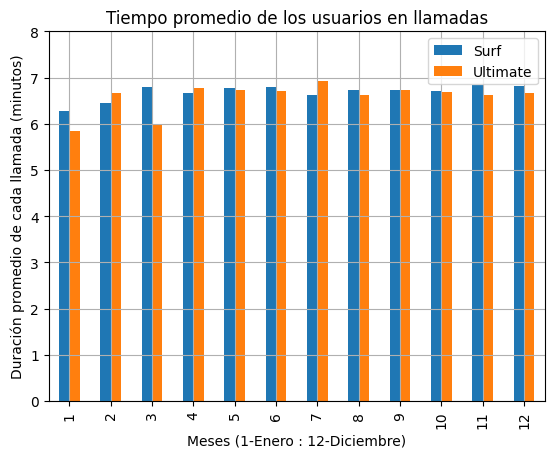

In [29]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
df_surf = general_df[general_df["plan"]=="surf"]
df_surf = df_surf.reset_index()
df_surf["avg_time_surf"] = 0.0
df_surf["avg_time_surf"] = df_surf["duration"] / df_surf["calls_per_month"]
df_surf = df_surf.drop(["index","user_id","plan","calls_per_month","duration","usd_monthly_pay","minutes_included","usd_per_minute","messages_included","quantity_msg","usd_per_message","mb_per_month_included","mb_used","usd_per_mb","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_surf_avg = df_surf.groupby(by="month").mean()

df_ultimate = general_df[general_df["plan"]=="ultimate"]
df_ultimate = df_ultimate.reset_index()
df_ultimate["avg_time_ult"] = 0.0
df_ultimate["avg_time_ult"] = df_ultimate["duration"] / df_ultimate["calls_per_month"]
df_ultimate = df_ultimate.drop(["index","user_id","plan","usd_monthly_pay","calls_per_month","duration","minutes_included","usd_per_minute","messages_included","quantity_msg","usd_per_message","mb_per_month_included","mb_used","usd_per_mb","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_ultimate_avg = df_ultimate.groupby(by="month").mean()

df_surf_vs_ult = df_surf_avg.merge(df_ultimate_avg,on="month")
df_surf_vs_ult.plot(title="Tiempo promedio de los usuarios en llamadas",
                    xlabel="Meses (1-Enero : 12-Diciembre)",
                    ylabel="Duración promedio de cada llamada (minutos)",
                    kind="bar",
                    grid=True, 
                    xlim=[1,12],
                    ylim=[0,8])
plt.legend(["Surf","Ultimate"])
plt.show()

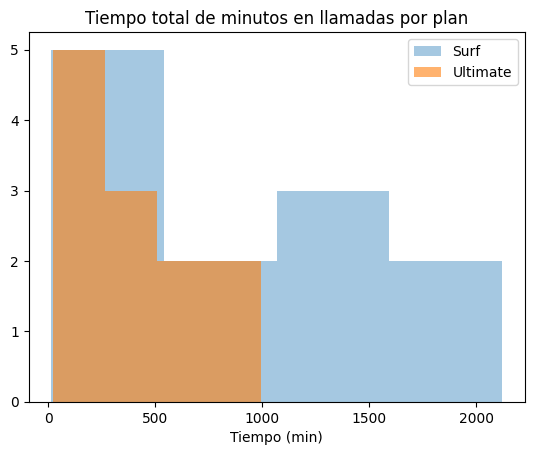

In [30]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_surf_sum = df_surf.groupby(by="month").sum()
df_ultimate_sum = df_ultimate.groupby(by="month").sum()

plt.hist(df_surf_sum, bins=4, alpha=0.4)
plt.hist(df_ultimate_sum, bins=4, alpha=0.6)
plt.title("Tiempo total de minutos en llamadas por plan")
plt.legend(["Surf","Ultimate"])
plt.xlabel("Tiempo (min)")
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [31]:
# Calcula la media y la varianza de la duración mensual de llamadas.
avg_surf = df_surf_sum["avg_time_surf"].mean()
print(f'El tiempo promedio de las llamadas en el plan Surf es: {avg_surf} minutos')
var_surf = np.var(df_surf_sum["avg_time_surf"])
print(f'La varianza del plan Surf es: {var_surf} min²')
print()

avg_ult = df_ultimate_sum["avg_time_ult"].mean()
print(f'El tiempo promedio de las llamadas en el plan Ultimate es: {avg_ult} minutos')
var_ult = np.var(df_ultimate_sum["avg_time_ult"])
print(f'La varianza del plan Ultimate es: {var_ult} min²')


El tiempo promedio de las llamadas en el plan Surf es: 869.9294392223628 minutos
La varianza del plan Surf es: 472324.8595956881 min²

El tiempo promedio de las llamadas en el plan Ultimate es: 396.7995505971913 minutos
La varianza del plan Ultimate es: 97132.52426530536 min²


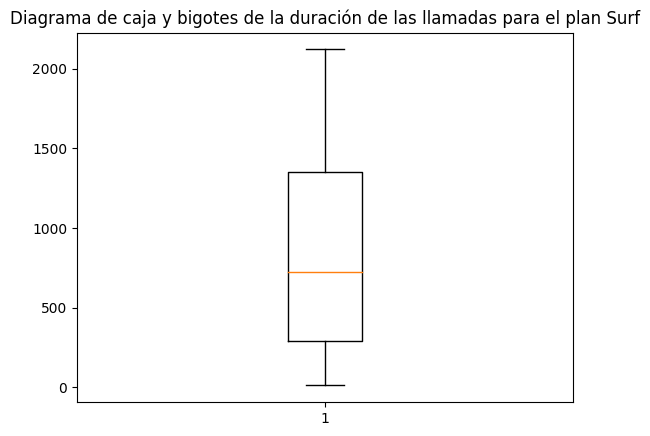

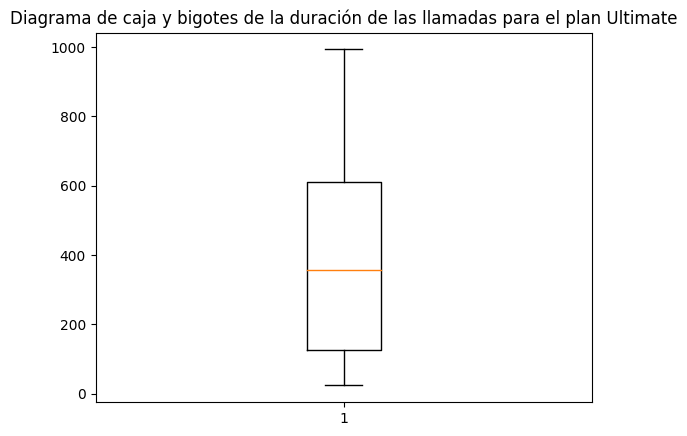

In [32]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.boxplot(df_surf_sum)
plt.title("Diagrama de caja y bigotes de la duración de las llamadas para el plan Surf")
plt.show()

plt.boxplot(df_ultimate_sum)
plt.title("Diagrama de caja y bigotes de la duración de las llamadas para el plan Ultimate")
plt.show()

**Independientemente del plan, los usuarios pasan en promedio el mismo tiempo llamando durante todo el año.**

**Si bien los usuarios del plan Surf pasan más tiempo llamando y tienen variaciones más altas en cuanto al tiempo total de llamadas al mes durante el transcurso del año en comparación a los usuarios del plan Ultimate, los diagramas de cajas muestran un comportamiento muy similar entre ambos planes.**

**Esto también los podemos notar en los histogramas ya que los del plan Surf tienen un sesgo a la derecha muy marcado y los del plan Ultimate también tienen un sesgo a la derecha pero menos pronunciado.**

### Mensajes

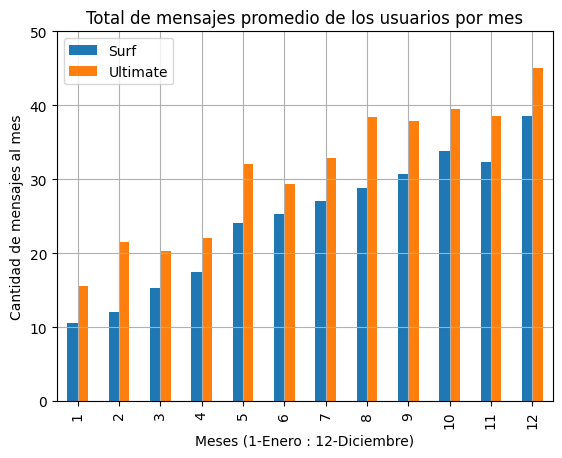

In [33]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
df_surf_msg = general_df[general_df["plan"]=="surf"]
df_surf_msg = df_surf_msg.reset_index()
df_surf_msg = df_surf_msg.drop(["user_id","index","messages_included","calls_per_month","duration","mb_used","plan","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_surf_msg = df_surf_msg.fillna(0)
df_surf_msg_avg = df_surf_msg.groupby(by="month").mean()

df_ult_msg = general_df[general_df["plan"]=="ultimate"]
df_ult_msg = df_ult_msg.reset_index()
df_ult_msg = df_ult_msg.drop(["user_id","index","messages_included","calls_per_month","duration","mb_used","plan","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_ult_msg = df_ult_msg.fillna(0)
df_ult_msg_avg = df_ult_msg.groupby(by="month").mean()

df_surf_vs_ult = df_surf_msg_avg.merge(df_ult_msg_avg,on="month")
df_surf_vs_ult.plot(title="Total de mensajes promedio de los usuarios por mes",
                    xlabel="Meses (1-Enero : 12-Diciembre)",
                    ylabel="Cantidad de mensajes al mes",
                    kind="bar",
                    grid=True, 
                    xlim=[1,12],
                    ylim=[0,50])
plt.legend(["Surf","Ultimate"])
plt.show()

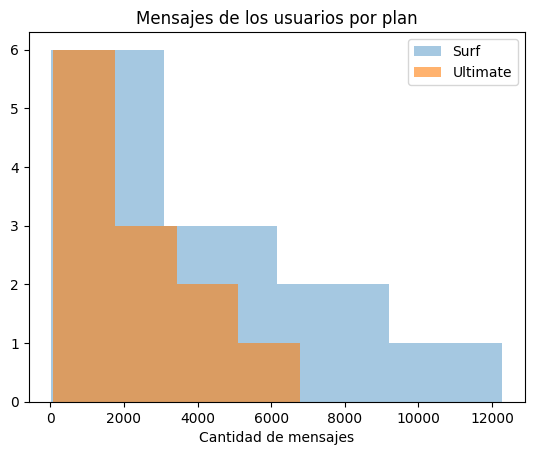

In [34]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_surf_sum = df_surf_msg.groupby(by="month").sum()
df_ultimate_sum = df_ult_msg.groupby(by="month").sum()

plt.hist(df_surf_sum, bins=4, alpha=0.4)
plt.hist(df_ultimate_sum, bins=4, alpha=0.6)
plt.title("Mensajes de los usuarios por plan")
plt.legend(["Surf","Ultimate"])
plt.xlabel("Cantidad de mensajes")
plt.show()

In [35]:
# Calcula la media y la varianza de la cantidad de mensajes.
avg_surf = df_surf_sum["quantity_msg"].mean()
var_surf = np.var(df_surf_sum["quantity_msg"])
print(f'La cantidad promedio de mensajes para el plan Surf es: {avg_surf} mensajes')
print(f'La varianza del plan Surf es: {var_surf} msg²')
print()

avg_ult = df_ultimate_sum["quantity_msg"].mean()
var_ult = np.var(df_ultimate_sum["quantity_msg"])
print(f'La cantidad promedio de mensajes para el plan Ultimate es: {avg_ult} mensajes')
print(f'La varianza del plan Ultimate es: {var_ult} msg²')

La cantidad promedio de mensajes para el plan Surf es: 4084.5 mensajes
La varianza del plan Surf es: 14764949.916666666 msg²

La cantidad promedio de mensajes para el plan Ultimate es: 2253.0833333333335 mensajes
La varianza del plan Ultimate es: 4307875.909722221 msg²


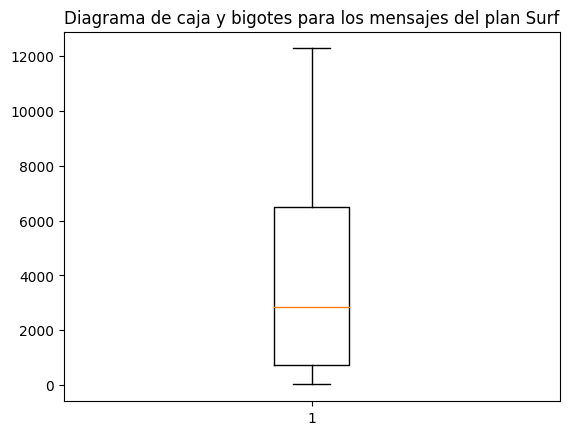

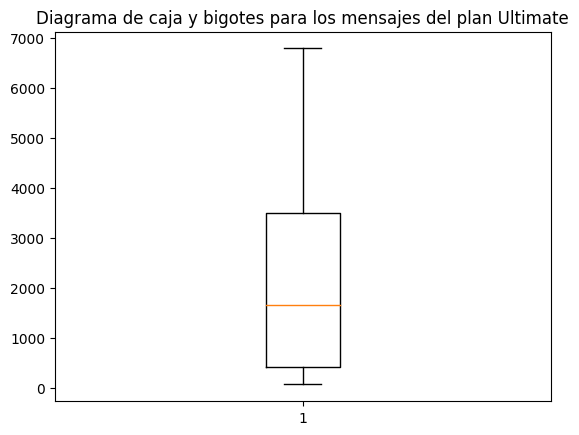

In [36]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes mensuales
plt.boxplot(df_surf_sum)
plt.title("Diagrama de caja y bigotes para los mensajes del plan Surf")
plt.show()

plt.boxplot(df_ultimate_sum)
plt.title("Diagrama de caja y bigotes para los mensajes del plan Ultimate")
plt.show()

**Basado en el histograma y los diagramas de cajas y bigotes, ambos planes tienen un comportamiento muy similar, tanto en el Surf como en el Ultimate ya que ambos presentan un sesgo a la derecha**

**Sin embargo, Aunque los usuarios del plan Surf mandan el doble de mensajes que los del plan Ultimate, podemos notar que los usuarios del plan Ultimate mandan mas mensajes al mes en promedio.**

### Internet

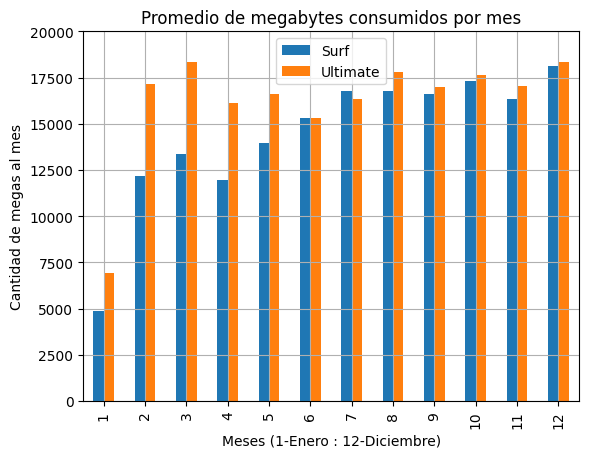

In [37]:
# Compara la cantidad de tráfico de Internet consumido por los usuarios al mes por plan
df_surf_mb = general_df[general_df["plan"]=="surf"]
df_surf_mb = df_surf_mb.reset_index()
df_surf_mb = df_surf_mb.drop(["user_id","index","messages_included","calls_per_month","duration","plan","quantity_msg","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_surf_mb = df_surf_mb.fillna(0)
df_surf_mb_avg = df_surf_mb.groupby(by="month").mean()

df_ult_mb = general_df[general_df["plan"]=="ultimate"]
df_ult_mb = df_ult_mb.reset_index()
df_ult_mb = df_ult_mb.drop(["user_id","index","messages_included","calls_per_month","duration","plan","quantity_msg","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb","total_fee"],axis=1)
df_ult_mb = df_ult_mb.fillna(0)
df_ult_mb_avg = df_ult_mb.groupby(by="month").mean()

df_surf_vs_ult = df_surf_mb_avg.merge(df_ult_mb_avg,on="month")
df_surf_vs_ult.plot(title="Promedio de megabytes consumidos por mes",
                    xlabel="Meses (1-Enero : 12-Diciembre)",
                    ylabel="Cantidad de megas al mes",
                    kind="bar",
                    grid=True, 
                    xlim=[1,12],
                    ylim=[0,20000])
plt.legend(["Surf","Ultimate"])
plt.show()

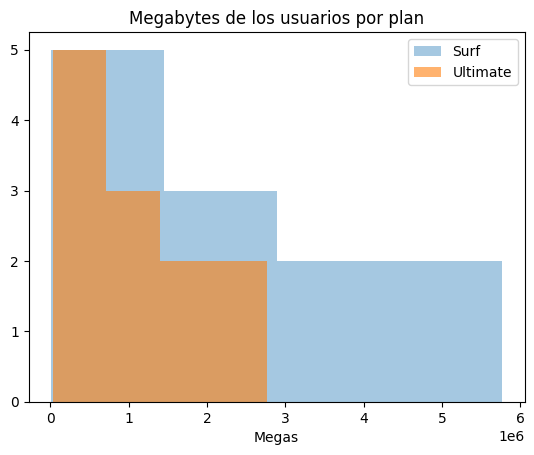

In [38]:
# Compara el número de megas mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_surf_sum = df_surf_mb.groupby(by="month").sum()
df_ultimate_sum = df_ult_mb.groupby(by="month").sum()

plt.hist(df_surf_sum, bins=4, alpha=0.4)
plt.hist(df_ultimate_sum, bins=4, alpha=0.6)
plt.title("Megabytes de los usuarios por plan")
plt.legend(["Surf","Ultimate"])
plt.xlabel("Megas")
plt.show()

In [39]:
# Calcula la media y la varianza de la cantidad de megas.
avg_surf = df_surf_sum["mb_used"].mean()
var_surf = np.var(df_surf_sum["mb_used"])
print(f'La cantidad promedio de megas para el plan Surf es: {avg_surf} megas')
print(f'La varianza del plan Surf es: {var_surf} mb²')
print()

avg_ult = df_ultimate_sum["mb_used"].mean()
var_ult = np.var(df_ultimate_sum["mb_used"])
print(f'La cantidad promedio de megas para el plan Ultimate es: {avg_ult} megas')
print(f'La varianza del plan Ultimate es: {var_ult} mb²')

La cantidad promedio de megas para el plan Surf es: 2170514.994166666 megas
La varianza del plan Surf es: 3386356625425.2886 mb²

La cantidad promedio de megas para el plan Ultimate es: 1032881.9816666665 megas
La varianza del plan Ultimate es: 717342663814.6989 mb²


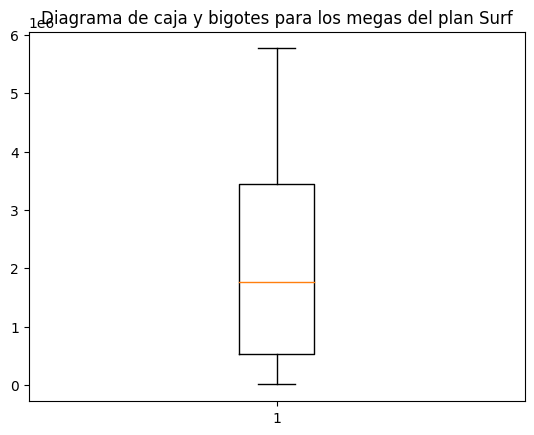

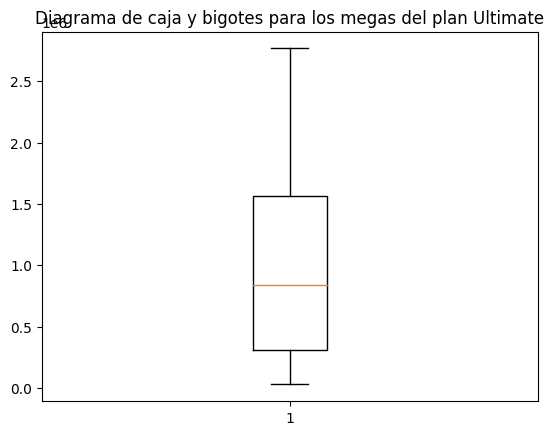

In [40]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes mensuales
plt.boxplot(df_surf_sum)
plt.title("Diagrama de caja y bigotes para los megas del plan Surf")
plt.show()
plt.boxplot(df_ultimate_sum)
plt.title("Diagrama de caja y bigotes para los megas del plan Ultimate")
plt.show()

**Al igual que en el caso de los mensajes se puede ver en el histograma y los diagramas de cajas y bigotes que ambos tienen comportamientos similares con sesgos a la derecha, aunque el de los usuarios del plan Surf es más marcado ese sesgo**

**Lo que si podemos ver claramente en el diagrama de barras es que los usuarios del plan Ultimate gastan en promedio un poco mas de megas que los del plan Surf, sobre todo el primer tetramestre del año. Y a partir de la mitad del año su comportamiento es muy similar** 

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

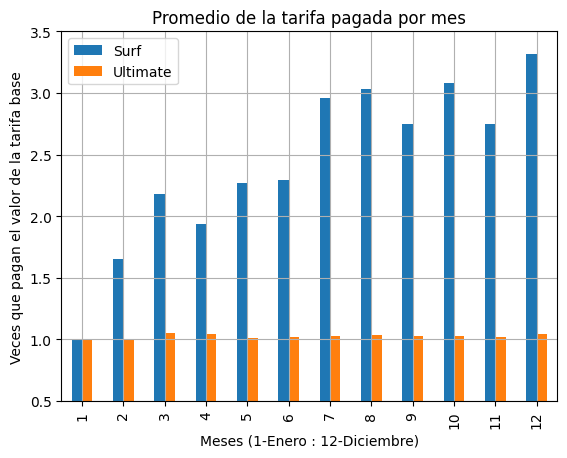

In [41]:
# Compara la tarifa de los usuarios al mes por plan
df_surf_fee = general_df[general_df["plan"]=="surf"]
df_surf_fee = df_surf_fee.reset_index()
df_surf_fee = df_surf_fee.drop(["mb_used","user_id","index","messages_included","calls_per_month","duration","plan","quantity_msg","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb"],axis=1)
df_surf_fee_avg = df_surf_fee.groupby(by="month").mean()
df_surf_fee_avg["total_fee"] = df_surf_fee_avg["total_fee"] / 20

df_ult_fee = general_df[general_df["plan"]=="ultimate"]
df_ult_fee = df_ult_fee.reset_index()
df_ult_fee = df_ult_fee.drop(["mb_used","user_id","index","messages_included","calls_per_month","duration","plan","quantity_msg","usd_monthly_pay","minutes_included","usd_per_minute","mb_per_month_included","usd_per_mb","usd_per_message","extra_charge_calls","extra_charge_msg","extra_charge_mb"],axis=1)
df_ult_fee_avg = df_ult_fee.groupby(by="month").mean()
df_ult_fee_avg["total_fee"] = df_ult_fee_avg["total_fee"] / 70

df_surf_vs_ult = df_surf_fee_avg.merge(df_ult_fee_avg,on="month")
df_surf_vs_ult.plot(title="Promedio de la tarifa pagada por mes",
                    xlabel="Meses (1-Enero : 12-Diciembre)",
                    ylabel="Veces que pagan el valor de la tarifa base",
                    kind="bar",
                    grid=True, 
                    ylim=[0.5,3.5])
plt.legend(["Surf","Ultimate"])
plt.show()

**Los usuarios del plan Surf pagan en promedio mas del doble de la tarifa base que pagan al mes, inclusive en algunos meses han llegado a pagar hasta 3 veces su valor, casi el mismo costo del plan Ultimate.**

**Mientras que los usuarios del plan Ultimate no consumen más de su tarifa base en todo el año.**

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [42]:
# Mi hipótesis nula es que los ingresos promedio son iguales
# Mi hipótesis alternativa es que son los ingresos promedios son distintos.

df_surf_fee_avg = df_surf_fee.groupby(by="month").mean()
df_ult_fee_avg = df_ult_fee.groupby(by="month").mean()

# Utilice el método de levene para saber si en equal_var se debía usar False o True, lo dejo comentado porque
# por algún error aquí en JN me marca un error.

#beta = 0.05
#w_stats, p_value = levene(df_surf_fee_avg,df_ult_fee_avg)
#if p_value < beta:
#    variable = False
#else:
#    variable = True

# Ahora utilizaré el método ttest_ind para probar si mi hipótesis de 2 medias son diferentes.

alpha = 0.05
results = st.ttest_ind(df_surf_fee_avg,df_ult_fee_avg,equal_var=False)

if results.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No podemor rechazar la hipótesis nula")

Se rechaza la hipótesis nula


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [43]:
# Antes de definir la hipótesis nula y alternativa, hay que construir los Dataframes con todos los usuarios de NY-NJ
# y el resto de usuarios.

# Primero voy a crear 2 DF uno con la suma de la tarifa de cada usuarios y otro con el número de tarifas para
# obtener el promedio.

df_users_citys = df_users[["user_id","city"]]
df_users_fees = general_df[["user_id","total_fee"]]
general_df_locations = df_users_fees.merge(df_users_citys,on="user_id",how="left")
user_fee_qty = general_df_locations.groupby(by="user_id").sum().reset_index()
user_fee_tot = general_df_locations.groupby(by="user_id").count().reset_index()

# Ahora los uno para posteriormente solo dividir la columan de la suma / cantidad de tarifas.

users_fee = user_fee_qty.merge(user_fee_tot,on="user_id",suffixes=["_qty","_sum"])
users_fee["total_fee_user"] = users_fee["total_fee_qty"] / users_fee["total_fee_sum"]
users_fee = users_fee.drop(["total_fee_qty","total_fee_sum"],axis=1)
users_fee = users_fee[["user_id","total_fee_user"]]

# Ahora voy a unir el último DF creado con el de los usuarios para obtener los nombres de las ciudades
# de cada uno de los usuarios. Para después tener 2 DF, uno con solo los usuarios de NY-NJ y otor con el
# resto de usuarios del país. 

users_fee = users_fee.merge(df_users,on="user_id")[["user_id","total_fee_user","city"]]
lista = ["new york-newark-jersey city, ny-nj-pa msa"]
users_ny_nj = users_fee.query("city in @lista")[["total_fee_user"]]
rest_users = users_fee.query("city not in @lista")[["total_fee_user"]]

# Mi hipótesis nula es que los ingresos promedio de los usuarios de NY-NJ son iguales a los de otras regiones.
# Mi hipótesis alternativa es que son los ingresos promedios son distintos.

alpha = 0.05
results = st.ttest_ind(users_ny_nj,rest_users,equal_var=True)

# Utilice el método de levene para saber si en equal_var se debía usar False o True, lo dejo comentado porque
# por algún error aquí en JN me marca un error.

#beta = 0.05
#w_stats, p_value = levene(users_ny_nj,rest_users)
#if p_value < beta:
#    variable = False
#else:
#    variable = True

# Ahora utilizaré el método ttest_ind para probar si mi hipótesis de 2 medias diferentes.

if results.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No podemor rechazar la hipótesis nula")

No podemor rechazar la hipótesis nula


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

**Primero que nada se tuvo que corregir el tipo de datos de algunos DF's, el costo por mb extra estaba dado en GB por lo cual se tuvo que hacer la conversión, se le dio formato de letras minúsculas a varios textos, se dio formato datetime a diferentes columna**

**En cuanto a los datos obtenidos con los diferente estudios, se pudo observar que los usuarios del plan Surf gastan más en llamadas, mensajes e internet en comparación a los del plan Ultimate, por ésto mismo en promedio pagan hasta 2 o 2.5 veces más la tarifa base de su plan. No se vio el estudio específico para cada usuarios, pero tal vez una búsqueda más a fondo para saber que usuarios gastan más y ofrecerles que paguen por el plan Ultimate podría ser mejor para ellos basados en su consumo.**

**En cuanto a las hipótesis se pudo ver que para los usuarios de los planes Surf y Ultimate las tarifas promedio son distintos. Y para la hipótesis de que los usuarios de NY-NJ tienen una tarifa promedio distitna al resto de los usuarios de otras ciudades pudimos observar que es falso ya que si tienen un comportamiento similar.**